In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


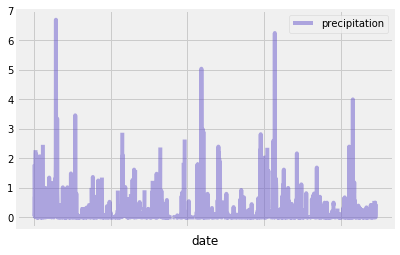

In [45]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True, color = "slateblue", alpha = 0.5)


![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
# Design a query to show how many stations are available in this dataset?
stations_avail = session.query(Station.station).count()
stations_avail


9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# stations_active = session.query(Measurement.station).group_by(Measurement.station)
station_dict = {}
for s in session.query(Measurement.station).group_by(Measurement.station):
    station_dict[s[0]] = session.query(Measurement.station).filter(Measurement.station == s[0]).count()

# List the stations and the counts in descending order.
station_count = pd.Series(station_dict).to_frame()
station_count.columns = ['rows']
station_count = station_count.sort_values('rows', ascending = False)
station_count


,rows
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for the most active station?
most_active_station = station_count.first_valid_index()
print(most_active_station)
low_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).one()[0]
high_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).one()[0]
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).one()[0]

print(low_temp)
print(high_temp)
print(avg_temp)

USC00519281
54.0
85.0
71.66378066378067


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if __name__ == '__main__':


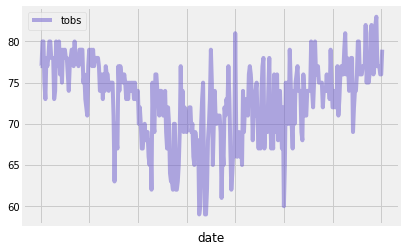

In [44]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

results = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= prev_year, Measurement.station == most_active_station).all()

df = pd.DataFrame(results, columns=['date', 'tobs'])
df.set_index(df['date'], inplace=True)

df = df.sort_values("date")

df.plot(x_compat=True, color = "slateblue", alpha = 0.5)


![precipitation](Images/station-histogram.png)

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2017-05-07', '2017-05-17')
trip_temp


[(66.0, 74.98360655737704, 80.0)]

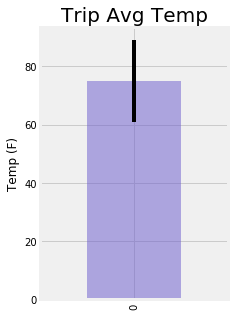

In [37]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_temp, columns = ['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind = 'bar', yerr = min_max_temp, figsize=(3,5), alpha=0.5, color='slateblue')
plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temp (F)")
plt.show()


In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_rainfall(start_date, end_date):
    return session.query(Measurement.prcp, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
        filter(Measurement.date >= start_date, Measurement.date <= end_date).all()

trip_rain = calc_rainfall('2017-05-07', '2017-05-10')
rain_df = pd.DataFrame(trip_rain)
rain_df = rain_df.sort_values(by = "prcp", ascending = False)
rain_df



,prcp,station,name,latitude,longitude,elevation
53,1.62,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
49,1.62,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
45,1.62,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
47,1.62,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
48,1.62,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
46,1.62,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
50,1.62,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
51,1.62,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
52,1.62,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
146,1.58,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [23]:
# Plot the daily normals as an area plot with `stacked=False`
